# Predicting GBP/USD Prices Using Random Forest
# a. Objective: Build a Random Forest model to predict prices based on historical data and technical indicators.
# b. Focus: Machine learning, feature engineering, and model evaluation.

In [ ]:
'''
Methodology 

1.	Data Loading and Preprocessing:
    	•	The script loads an hourly candlestick dataset for GBP/USD.
    	•	The Local time column is parsed into a datetime format and set as the index.
    	•	Technical indicators are calculated for feature engineering:
    	•	Moving Averages (MA): MA_5 (5-period) and MA_50 (50-period) simple moving averages.
    	•	Exponential Moving Average (EMA): EMA_10 (10-period).
    	•	Relative Strength Index (RSI): Measures the magnitude of recent gains versus losses over a 14-period window.
    	•	Moving Average Convergence Divergence (MACD): The difference between 12-period and 26-period EMAs.
    	•	Bollinger Bands: Bollinger_Upper and Bollinger_Lower, representing upper and lower bounds for the 20-period moving average.

2.	Target Creation:
    	•	The target variable, Target, is set as the next hour’s closing price by shifting the Close column by one period backward.

3.	Data Splitting:
    	•	The data is split into training and testing sets (70% training, 30% testing) without shuffling to preserve the time series order.

4.	Model Training:
    	•	A RandomForestRegressor model is initialized with 100 trees (n_estimators=100) and a maximum depth of 10 (max_depth=10).
    	•	The model is trained on the training data.

5.	Prediction and Evaluation:
    	•	Predictions are made on the test set.
    	•	The model’s performance is evaluated using:
    	•	R-squared: Indicates how well the model explains the variability of the target.
    	•	Mean Absolute Error (MAE): Average magnitude of errors.
    	•	Root Mean Squared Error (RMSE): Measures the standard deviation of prediction errors.
    	•	A plot shows actual vs. predicted closing prices over time for visual inspection.

6.	Cross-Validation:
    	•	TimeSeriesSplit cross-validation is used to ensure robustness, and reliability, splitting the data into six sequential folds.
    	•	R-squared scores for each fold are calculated, and their mean is displayed.
'''     

In [9]:
#imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os


R-squared: 0.9973181176173804
MAE: 0.0007603124238383202
RMSE: 0.0011240297944161797


C:\Users\runad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


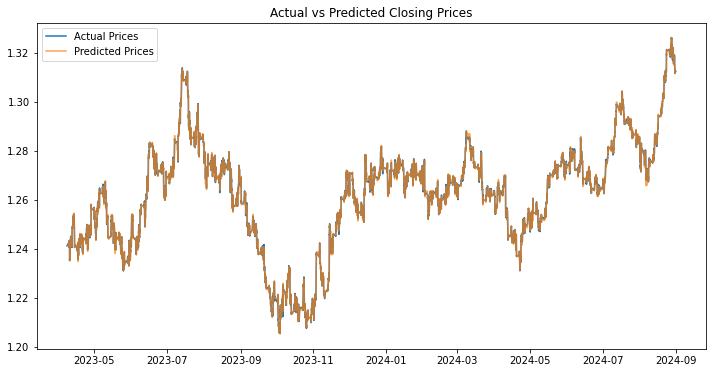

Cross-Validation R-squared scores: [0.4816529  0.99676382 0.99897772 0.85352392 0.99734473 0.99630806]
Mean R-squared score from cross-validation: 0.8874285271853982


In [7]:

# Load the dataset and perform existing preprocessing steps
file_path = 'GBPUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv'
data = pd.read_csv(file_path)
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)
data.set_index('Local time', inplace=True)
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
window_length = 14
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['Bollinger_Upper'] = data['MA_20'] = data['Close'].rolling(window=20).mean() + (2 * data['Close'].rolling(window=20).std())
data['Bollinger_Lower'] = data['MA_20'] - (2 * data['Close'].rolling(window=20).std())
data['Target'] = data['Close'].shift(-1)
data = data.dropna()
X = data.drop(['Target'], axis=1)
Y = data['Target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, Y_train)


# Predict and evaluate the model
Y_pred = rf_model.predict(X_test)
print(f"R-squared: {r2_score(Y_test, Y_pred)}")
print(f"MAE: {mean_absolute_error(Y_test, Y_pred)}")
print(f"RMSE: {mean_squared_error(Y_test, Y_pred, squared=False)}")
plt.figure(figsize=(12, 6))
plt.plot(Y_test.index, Y_test, label='Actual Prices')
plt.plot(Y_test.index, Y_pred, label='Predicted Prices', alpha=0.7)
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()


# Cross-validation for robustness
tscv = TimeSeriesSplit(n_splits=6)
cross_val_scores = cross_val_score(rf_model, X, Y, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_val_scores}")
print(f"Mean R-squared score from cross-validation: {cross_val_scores.mean()}")


In [ ]:
'''
Interpretation :

1.	R-squared (0.9973):
	•	This value, close to 1, indicates that the model explains about 99.73% of the variance in the target (GBP/USD closing prices).
	•	A high R-squared suggests that the model is performing very well in capturing the underlying pattern in the data.
2.	Mean Absolute Error (MAE, 0.00076):
	•	This metric shows the average absolute difference between the predicted and actual prices.
	•	An MAE of 0.00076 means that, on average, the model’s predictions are off by 0.00076 units in GBP/USD terms, indicating highly           accurate predictions.
3.	Root Mean Squared Error (RMSE, 0.0011):
	•	RMSE gives more weight to larger errors and is often used to penalize bigger deviations.
	•	An RMSE of 0.0011 suggests that the standard deviation of the prediction errors is very low, reinforcing that the model is making 	     accurate predictions with minimal large errors.
'''

In [ ]:
'''
1.	Cross-Validation R-squared Scores:
	•	The R-squared scores for each fold vary: [0.4803, 0.9968, 0.9990, 0.8526, 0.9973, 0.9963].
	•	This variation suggests that the model performs well on some splits but has a lower R-squared in certain periods (e.g., 0.4803).
	•	This inconsistency could indicate that some segments of the data are more challenging to predict accurately, possibly due to changes in market patterns or volatility.
2.	Mean R-squared Score (0.8870):
	•	The average R-squared across all folds is approximately 0.8870, indicating that, on average, the model explains about 88.7% of the variance across different time periods.
'''	

Ensemble R-squared: 0.9974112239311393
Ensemble MAE: 0.0007465179754530997
Ensemble RMSE: 0.001104346100664396


C:\Users\runad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


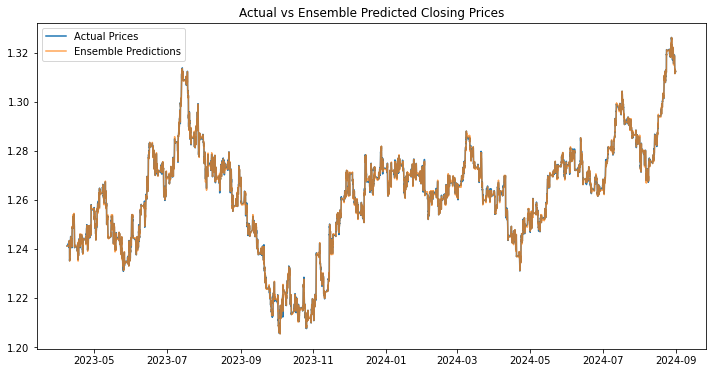

Cross-Validation R-squared scores: [0.4816529  0.99676382 0.99897772 0.85352392 0.99734473 0.99630806]
Mean R-squared score from cross-validation: 0.8874285271853982


In [8]:
#Burlyn
#print(data.head())

# Function for ensemble prediction
def ensemble_predictor(models, X_train, Y_train, X_test):
    """
    Combines predictions from multiple models by averaging.
    
    Args:
        models (list): List of models to include in the ensemble.
        X_train (pd.DataFrame): Training feature set.
        Y_train (pd.Series): Training target values.
        X_test (pd.DataFrame): Test feature set.
    
    Returns:
        np.ndarray: Ensemble predictions on the test set.
    """
    predictions = []
    for model in models:
        model.fit(X_train, Y_train)
        predictions.append(model.predict(X_test))
    
    # Average predictions from all models
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred


# Define models
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Create ensemble predictions
models = [rf_model, gb_model]
ensemble_predictions = ensemble_predictor(models, X_train, Y_train, X_test)

# Evaluate the ensemble model
print(f"Ensemble R-squared: {r2_score(Y_test, ensemble_predictions)}")
print(f"Ensemble MAE: {mean_absolute_error(Y_test, ensemble_predictions)}")
print(f"Ensemble RMSE: {mean_squared_error(Y_test, ensemble_predictions, squared=False)}")

# Plot ensemble predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test.index, Y_test, label='Actual Prices')
plt.plot(Y_test.index, ensemble_predictions, label='Ensemble Predictions', alpha=0.7)
plt.title('Actual vs Ensemble Predicted Closing Prices')
plt.legend()
plt.show()

# Cross-validation for robustness
tscv = TimeSeriesSplit(n_splits=6)
cross_val_scores = cross_val_score(rf_model, X, Y, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_val_scores}")
print(f"Mean R-squared score from cross-validation: {cross_val_scores.mean()}")

In [14]:
#source: https://www.kaggle.com/datasets/thebasss/currency-exchange-rates/data

df=pd.read_csv("currency_exchange_rates_02-01-1995_-_02-05-2018.csv")
print(list(df.columns))
print(df.head())

['Date', 'Algerian Dinar', 'Australian Dollar', 'Bahrain Dinar', 'Bolivar Fuerte', 'Botswana Pula', 'Brazilian Real', 'Brunei Dollar', 'Canadian Dollar', 'Chilean Peso', 'Chinese Yuan', 'Colombian Peso', 'Czech Koruna', 'Danish Krone', 'Euro', 'Hungarian Forint', 'Icelandic Krona', 'Indian Rupee', 'Indonesian Rupiah', 'Iranian Rial', 'Israeli New Sheqel', 'Japanese Yen', 'Kazakhstani Tenge', 'Korean Won', 'Kuwaiti Dinar', 'Libyan Dinar', 'Malaysian Ringgit', 'Mauritian Rupee', 'Mexican Peso', 'Nepalese Rupee', 'New Zealand Dollar', 'Norwegian Krone', 'Nuevo Sol', 'Pakistani Rupee', 'Peso Uruguayo', 'Philippine Peso', 'Polish Zloty', 'Qatar Riyal', 'Rial Omani', 'Russian Ruble', 'Saudi Arabian Riyal', 'Singapore Dollar', 'South African Rand', 'Sri Lanka Rupee', 'Swedish Krona', 'Swiss Franc', 'Thai Baht', 'Trinidad And Tobago Dollar', 'Tunisian Dinar', 'U.A.E. Dirham', 'U.K. Pound Sterling', 'U.S. Dollar']
       Date  Algerian Dinar  Australian Dollar  Bahrain Dinar  Bolivar Fuerte  \


R-squared (USD & Euro): 0.9289299035907487
MAE (USD & Euro): 0.01059365016438257
RMSE (USD & Euro): 0.014553906336465864


C:\Users\runad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


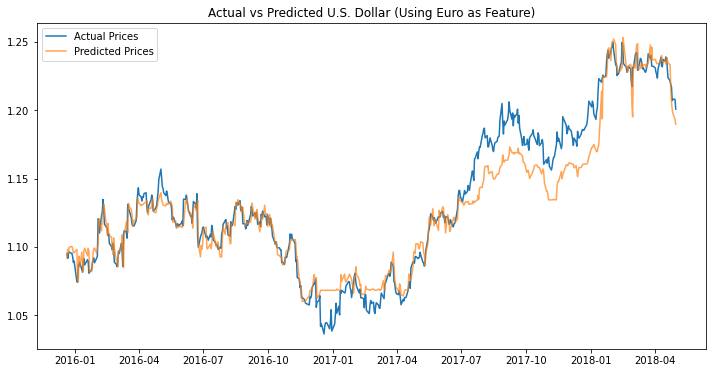

Cross-Validation R-squared scores (USD & Euro): [  0.95884174   0.88506353   0.9785557  -10.58633256   0.89242298
   0.87102545]
Mean R-squared score from cross-validation (USD & Euro): -1.000070527564218


In [15]:
data_new = pd.read_csv("currency_exchange_rates_02-01-1995_-_02-05-2018.csv")
data_new['Date'] = pd.to_datetime(data_new['Date'])
data_new.set_index('Date', inplace=True)

# Handle missing values (e.g., forward fill)
data_new.ffill(inplace=True)
data_new.dropna(inplace=True)  # Drop remaining rows with missing data if any

# Select only U.S. Dollar and Euro columns for analysis
usd_euro_data = data_new[['U.S. Dollar', 'Euro']].copy()

# Feature Engineering: Moving averages and other features
usd_euro_data['USD_MA_5'] = usd_euro_data['U.S. Dollar'].rolling(window=5).mean()
usd_euro_data['USD_MA_50'] = usd_euro_data['U.S. Dollar'].rolling(window=50).mean()
usd_euro_data['USD_EMA_10'] = usd_euro_data['U.S. Dollar'].ewm(span=10, adjust=False).mean()

usd_euro_data['Euro_MA_5'] = usd_euro_data['Euro'].rolling(window=5).mean()
usd_euro_data['Euro_MA_50'] = usd_euro_data['Euro'].rolling(window=50).mean()
usd_euro_data['Euro_EMA_10'] = usd_euro_data['Euro'].ewm(span=10, adjust=False).mean()

# Target variable: Predicting the next U.S. Dollar value
usd_euro_data["Target"] = usd_euro_data["Euro"].shift(-1)

# Drop rows with NaN after feature creation
usd_euro_data.dropna(subset=["Target"], inplace=True)

usd_euro_data = usd_euro_data.drop(columns=["U.S. Dollar", "USD_MA_5", "USD_MA_50", "USD_EMA_10"])

# Features (X) and Target (Y)
X_usd_euro = usd_euro_data.drop(['Target'], axis=1)
Y_usd_euro = usd_euro_data['Target']

# Train-test split
X_train_usd_euro, X_test_usd_euro, Y_train_usd_euro, Y_test_usd_euro = train_test_split(
    X_usd_euro, Y_usd_euro, test_size=0.3, shuffle=False
)

# Train Random Forest model
rf_model_usd_euro = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model_usd_euro.fit(X_train_usd_euro, Y_train_usd_euro)

# Predict and evaluate
Y_pred_usd_euro = rf_model_usd_euro.predict(X_test_usd_euro)

# Evaluation Metrics
print(f"R-squared (USD & Euro): {r2_score(Y_test_usd_euro, Y_pred_usd_euro)}")
print(f"MAE (USD & Euro): {mean_absolute_error(Y_test_usd_euro, Y_pred_usd_euro)}")
print(f"RMSE (USD & Euro): {mean_squared_error(Y_test_usd_euro, Y_pred_usd_euro, squared=False)}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(Y_test_usd_euro.index, Y_test_usd_euro, label='Actual Prices')
plt.plot(Y_test_usd_euro.index, Y_pred_usd_euro, label='Predicted Prices', alpha=0.7)
plt.title('Actual vs Predicted U.S. Dollar (Using Euro as Feature)')
plt.legend()
plt.show()

# Cross-validation for robustness
tscv_usd_euro = TimeSeriesSplit(n_splits=6)
cross_val_scores_usd_euro = cross_val_score(rf_model_usd_euro, X_usd_euro, Y_usd_euro, cv=tscv_usd_euro, scoring='r2')
print(f"Cross-Validation R-squared scores (USD & Euro): {cross_val_scores_usd_euro}")
print(f"Mean R-squared score from cross-validation (USD & Euro): {cross_val_scores_usd_euro.mean()}")

In [16]:
correlation_matrix = usd_euro_data.corr()
print(correlation_matrix["Target"])


Euro           0.998051
Euro_MA_5      0.995732
Euro_MA_50     0.969560
Euro_EMA_10    0.994166
Target         1.000000
Name: Target, dtype: float64


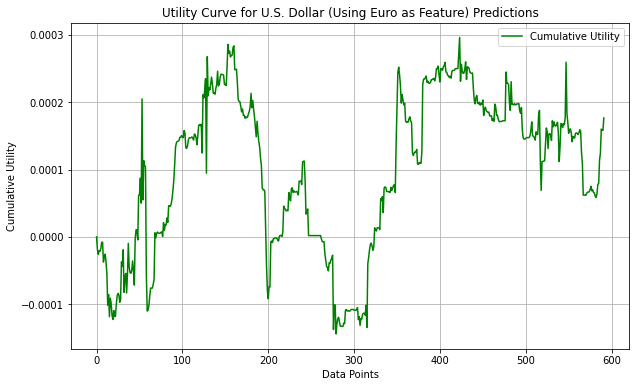

In [18]:
y_test = np.array(Y_test_usd_euro)
y_pred = np.array(Y_pred_usd_euro)

# Calculate returns for actual and predicted prices
actual_returns = pd.Series(y_test).pct_change().fillna(0)
predicted_returns = pd.Series(y_pred).pct_change().fillna(0)

# Reset indices to avoid timestamp conflicts
actual_returns.reset_index(drop=True, inplace=True)
predicted_returns.reset_index(drop=True, inplace=True)

# Utility function: simple product of predicted and actual returns
utility = predicted_returns * actual_returns

# Cumulative utility calculation
cumulative_utility = np.cumsum(utility)

# Plot cumulative utility
plt.figure(figsize=(10, 6))
plt.plot(cumulative_utility, label='Cumulative Utility', color='green')
plt.title('Utility Curve for U.S. Dollar (Using Euro as Feature) Predictions')
plt.xlabel('Data Points')
plt.ylabel('Cumulative Utility')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
#Data Preparation - load df
AUDUSD = pd.read_csv("FinancialInstruments\AUDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
BRENT_CMDUSD = pd.read_csv("FinancialInstruments\BRENT.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
BTCUSD = pd.read_csv("FinancialInstruments\BTCUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
COCOA_CMDUSD = pd.read_csv("FinancialInstruments\COCOA.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
COFFEE_CMDUSX = pd.read_csv("FinancialInstruments\COFFEE.CMDUSX_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
COPPER_CMDUSD = pd.read_csv("FinancialInstruments\COPPER.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
COTTON_CMDUSX = pd.read_csv("FinancialInstruments\COTTON.CMDUSX_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
DIESEL_CMDUSD = pd.read_csv("FinancialInstruments\DIESEL.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
DOLLAR_IDXUSD = pd.read_csv("FinancialInstruments\DOLLAR.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
ETHUSD = pd.read_csv("FinancialInstruments\ETHUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
EURUSD = pd.read_csv("FinancialInstruments\EURUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
GAS_CMDUSD = pd.read_csv("FinancialInstruments\GAS.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
GBPUSD = pd.read_csv("FinancialInstruments\GBPUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
LIGHT_CMDUSD = pd.read_csv("FinancialInstruments\LIGHT.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
NZDUSD = pd.read_csv("FinancialInstruments\\NZDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
OJUICE_CMDUSX = pd.read_csv("FinancialInstruments\OJUICE.CMDUSX_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
SOYBEAN_CMDUSX = pd.read_csv("FinancialInstruments\SOYBEAN.CMDUSX_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
SUGAR_CMDUSD = pd.read_csv("FinancialInstruments\SUGAR.CMDUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
UKGILT_TRGBP = pd.read_csv("FinancialInstruments\\UKGILT.TRGBP_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USA30_IDXUSD = pd.read_csv("FinancialInstruments\\USA30.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USA500_IDXUSD = pd.read_csv("FinancialInstruments\\USA500.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USATECH_IDXUSD = pd.read_csv("FinancialInstruments\\USATECH.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USDCAD = pd.read_csv("FinancialInstruments\\USDCAD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USDCHF = pd.read_csv("FinancialInstruments\\USDCHF_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USDJPY = pd.read_csv("FinancialInstruments\\USDJPY_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USSC2000_IDXUSD = pd.read_csv("FinancialInstruments\\USSC2000.IDXUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
USTBOND_TRUSD = pd.read_csv("FinancialInstruments\\USTBOND.TRUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
XAGUSD = pd.read_csv("FinancialInstruments\XAGUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")
XAUUSD = pd.read_csv("FinancialInstruments\XAUUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv")

print(BTCUSD.head())

                         Local time  Open  High   Low  Close  Volume
0  01.01.2020 00:00:00.000 GMT-0500  7101  7101  7101   7101     0.0
1  01.01.2020 01:00:00.000 GMT-0500  7101  7101  7101   7101     0.0
2  01.01.2020 02:00:00.000 GMT-0500  7101  7101  7101   7101     0.0
3  01.01.2020 03:00:00.000 GMT-0500  7101  7101  7101   7101     0.0
4  01.01.2020 04:00:00.000 GMT-0500  7101  7101  7101   7101     0.0


In [8]:
folder_path = "FinancialInstruments"

# List to store DataFrames
data_frames = {}

# Load each CSV
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        instrument_name = file.split("_")[0]
        df = pd.read_csv(os.path.join(folder_path, file), parse_dates=["Local time"], dayfirst=True)
        data_frames[instrument_name] = df

# Example preprocessing for each dataset
for name, df in data_frames.items():
    df['Local time'] = pd.to_datetime(df['Local time'], errors='coerce')
    df.dropna(subset=['Local time'], inplace=True)
    df.set_index('Local time', inplace=True)
    data_frames[name] = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Use GBPUSD as target variable
gbpusd = data_frames["GBPUSD"]
target = gbpusd['Close']

# Combine and align
features_df = pd.concat(data_frames.values(), axis=1).dropna()

# Train-test split
X = features_df.drop(columns=['Close'])
y = target.loc[X.index]  # Ensure target aligns with feature timestamps

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

R-squared: 0.9998359184480811
MAE: 0.00043191207973144693
RMSE: 0.0007666112179479916


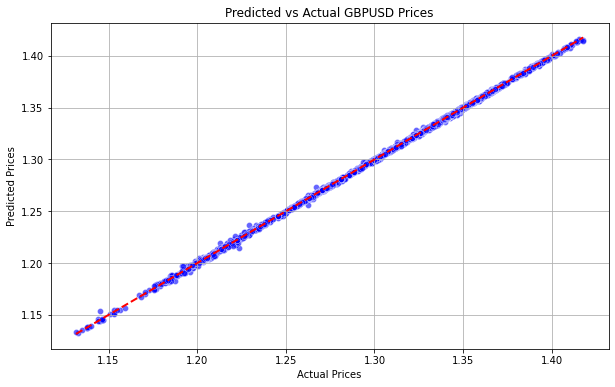

In [10]:
y_pred = rf.predict(X_test_scaled)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Predicted vs Actual GBPUSD Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

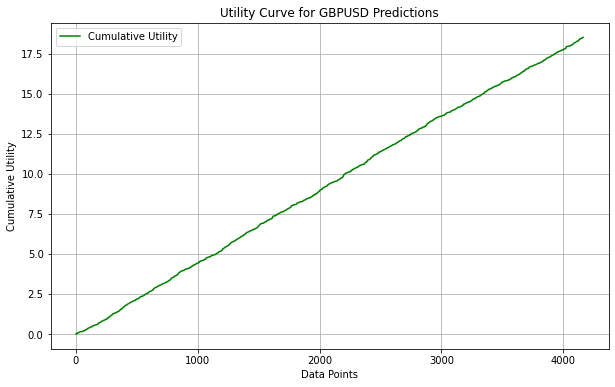

In [13]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate returns for actual and predicted prices
actual_returns = pd.Series(y_test).pct_change().fillna(0)
predicted_returns = pd.Series(y_pred).pct_change().fillna(0)

# Reset indices to avoid timestamp conflicts
actual_returns.reset_index(drop=True, inplace=True)
predicted_returns.reset_index(drop=True, inplace=True)

# Utility function: simple product of predicted and actual returns
utility = predicted_returns * actual_returns

# Cumulative utility calculation
cumulative_utility = np.cumsum(utility)

# Plot cumulative utility
plt.figure(figsize=(10, 6))
plt.plot(cumulative_utility, label='Cumulative Utility', color='green')
plt.title('Utility Curve for GBPUSD Predictions')
plt.xlabel('Data Points')
plt.ylabel('Cumulative Utility')
plt.grid(True)
plt.legend()
plt.show()